<a href="https://colab.research.google.com/github/Fernando3161/GridObserver/blob/main/GirdObserver_ReactiveLoad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandapower
!pip install python-igraph

In [ ]:
import pandas as pd
import pandapower as pp
import numpy as np
import copy

In [ ]:
# This is a dummy grid that will be used as experimentation object

def create_net(houses=3, f_l=1, f_pv=1):
    """
    f_1: Factor for scaling the loads (Too big netwokrs require lower loads for
          the network to function)
    f_pv: Factor for scaling the PVs Gens (To produce overvoltages)

    Simple net that looks like:

    ext_grid b0
    |
    b1
    |
    trafo(10/0.4)
    |
    b2
    |
    b3--------------b4 -------------b5-------------and more elements
    |               |               |
    |-----|----|    |-----|-----|   |-----|-----|
    load  sto  PV   load  sto  PV   load  sto  PV
    """
    net = pp.create_empty_network()

    b0 = pp.create_bus(net, vn_kv=10, name="bus0_grid")
    b1 = pp.create_bus(net, vn_kv=10, name="bus1_trafo_hv" )
    b2 = pp.create_bus(net, vn_kv=0.4, name="bus2_trafo_lv")
    
    # houses_buses__list
    hbl=[]
    for i in range(houses):
      b = pp.create_bus(net, vn_kv=0.4, name=f"bus_house_{i}")
      hbl.append(b)

    # External grid
    pp.create_ext_grid(net, b0)
    pp.create_line(net, b0, b1, 0.20, "34-AL1/6-ST1A 10.0")

    # Transformer
    pp.create_transformer(net, b1, b2, "0.4 MVA 10/0.4 kV", name='tr1')
    
    # Line for the first house
    pp.create_line(net, b2, hbl[0], 0.20, "34-AL1/6-ST1A 10.0")

    # Line for from the n house to the n+1 house
    for i in range(houses-1):
      pp.create_line(net, hbl[i], hbl[i+1], 0.20, "94-AL1/15-ST1A 0.4")
    
    # Create the elements of the buses
    # Load starts at 30, 40, 50 kW
    # SGens are PVs and go from 10,15,20 kW
    # Storages are assumed to be at 50% and can charge or discharge

    for i,b in enumerate(hbl):
        pp.create_load(net, b, p_mw=(30 + 10 * i)*f_l, q_mvar=0,
                       name=f'load{i}', scaling=1 / 1000)
        pp.create_sgen(net, b, p_mw=(10 + 5 * i)*f_pv, q_mvar=0,
                       name=f'sgen{i}', scaling=1 / 1000)
        pp.create_storage(net, bus=b, p_mw=0, q_mvar=0, max_e_mwh=1000, 
                          name=f'storage{i}', scaling=1 / 1000)

    return net

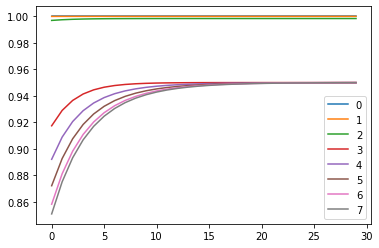

In [ ]:
# Example only with active load
net = create_net(5, f_l=0.66)
pp.runpp(net)

# Dataframe to save each iteration
bus_res=pd.DataFrame()
bus_res[0]=net.res_bus["vm_pu"]
k=1
converge = False
while not converge:
  jacobian = net._ppc["internal"]["J"].todense()
  list_v = [0]*(len(net.res_bus["vm_pu"])-1)

  for v in net.res_bus["vm_pu"][1:]:  # 0 is always the slack
      if v < 0.95:
          dv = (0.95 - v)*400
      elif v > 1.05:
          dv = (1.05 - v)*400
      else:
          dv = 0
      list_v.append(dv)

  deltas_mx = np.dot(jacobian, list_v)
  for i in net.storage.index:
    # here a limit can be implemented
    lim = 200
    if net.storage.at[i,"p_mw"]-deltas_mx[0,i+2]>lim:
      net.storage.at[i,"p_mw"]=lim
    
    elif net.storage.at[i,"p_mw"]-deltas_mx[0,i+2]<-lim:
      net.storage.at[i,"p_mw"]=-lim
    else:
      net.storage.at[i,"p_mw"]-=deltas_mx[0,i+2]

  pp.runpp(net)
  net.res_bus
  bus_res[k]=net.res_bus["vm_pu"]
  if min(bus_res)>0.95 and max(bus_res)<1.05:
    converge = True
  
  if not converge:
    diff =bus_res[k]-bus_res[k-1]
    if max(diff)<1/40000:
      converge = True
    else:
      k+=1

bus_res.T.plot()

In [ ]:
net.storage


,name,bus,p_mw,q_mvar,sn_mva,soc_percent,min_e_mwh,max_e_mwh,scaling,in_service,type
0,storage0,3,33.922378,0.0,NaN,NaN,0.0,1000.0,0.001,True,None
1,storage1,4,-11.391009,0.0,NaN,NaN,0.0,1000.0,0.001,True,None
2,storage2,5,-12.985853,0.0,NaN,NaN,0.0,1000.0,0.001,True,None
3,storage3,6,-14.580649,0.0,NaN,NaN,0.0,1000.0,0.001,True,None
4,storage4,7,-16.176435,0.0,NaN,NaN,0.0,1000.0,0.001,True,None


In [ ]:
net.res_bus

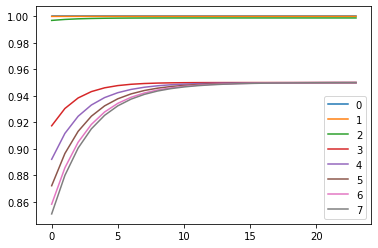

In [ ]:
# now with Qs... requires negative reactive power
# Example only with active load
net = create_net(5, f_l=0.66)
pp.runpp(net)

# Dataframe to save each iteration
bus_res=pd.DataFrame()
bus_res[0]=net.res_bus["vm_pu"]
k=1
converge = False
while not converge:
  jacobian = net._ppc["internal"]["J"].todense()
  list_v = [0]*(len(net.res_bus["vm_pu"])-1)

  for v in net.res_bus["vm_pu"][1:]:  # 0 is always the slack
      if v < 0.95:
          dv = (0.95 - v)*400
      elif v > 1.05:
          dv = (1.05 - v)*400
      else:
          dv = 0
      list_v.append(dv)

  deltas_mx = np.dot(jacobian, list_v)
  for i in net.storage.index:
    # here a limit can be implemented
    lim = 200
    cos_phi = 0.95
    tan_phi=(1-cos_phi**2)**0.5/cos_phi
    if net.storage.at[i,"p_mw"]-deltas_mx[0,i+2]>lim:
      net.storage.at[i,"p_mw"]=lim
    
    elif net.storage.at[i,"p_mw"]-deltas_mx[0,i+2]<-lim:
      net.storage.at[i,"p_mw"]=-lim
    else:
      net.storage.at[i,"p_mw"]-=deltas_mx[0,i+2]
    
    # What is the sign of the reactive power in the node?
    net.storage.at[i,"q_mvar"]-=deltas_mx[0,i+2+7]
    if abs(net.storage.at[i,"q_mvar"])>abs(net.storage.at[i,"p_mw"]*tan_phi):
      net.storage.at[i,"q_mvar"] = net.storage.at[i,"p_mw"]*tan_phi
  pp.runpp(net)
  net.res_bus
  bus_res[k]=net.res_bus["vm_pu"]

  if min(bus_res)>0.95 and max(bus_res)<1.05:
      converge = True
  
  if not converge:
    diff =bus_res[k]-bus_res[k-1]
    if max(diff)<1/40000:
      converge = True
    else:
      k+=1
  

bus_res.T.plot()


In [ ]:
net.storage


,name,bus,p_mw,q_mvar,sn_mva,soc_percent,min_e_mwh,max_e_mwh,scaling,in_service,type
0,storage0,3,23.598981,7.756610,NaN,NaN,0.0,1000.0,0.001,True,None
1,storage1,4,-8.851095,-2.898463,NaN,NaN,0.0,1000.0,0.001,True,None
2,storage2,5,-10.011803,-3.290720,NaN,NaN,0.0,1000.0,0.001,True,None
3,storage3,6,-11.166236,-3.670164,NaN,NaN,0.0,1000.0,0.001,True,None
4,storage4,7,-12.347432,-4.058404,NaN,NaN,0.0,1000.0,0.001,True,None


In [ ]:
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,-0.050108,0.004597
1,0.999920,-0.002504,0.000000,0.000000
2,0.998716,-0.279798,0.000000,0.000000
3,0.950016,-1.914045,0.033399,0.007757
4,0.949985,-2.547148,0.002549,-0.002898
5,0.949970,-3.051224,0.002988,-0.003291
6,0.949957,-3.406617,0.003434,-0.003670
7,0.949949,-3.593850,0.003853,-0.004058
